In [1]:
#Importing all the relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
#Load the dataset
data_path = 'data.csv'  # Replace with your dataset path
data = pd.read_csv(data_path)

Understanding the data

In [3]:
#Check data types
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Crash_Severity          300 non-null    object 
 1   Vehicle_Speed           300 non-null    int64  
 2   Crash_Time              300 non-null    int64  
 3   Age                     300 non-null    int64  
 4   Gender                  300 non-null    object 
 5   Vehicle_Type            300 non-null    object 
 6   Number_of_Lanes         300 non-null    int64  
 7   Lane_Width              300 non-null    float64
 8   Road_Type               300 non-null    object 
 9   Alcohol_Consumption     300 non-null    object 
 10  Crash_Type              300 non-null    object 
 11  Seatbelt_Usage          300 non-null    object 
 12  Speed_Limit             300 non-null    int64  
 13  Road_Surface_Condition  300 non-null    object 
dtypes: float64(1), int64(5), object(8)
memory 

In [4]:
#check for null values
data.isnull().sum()

Crash_Severity            0
Vehicle_Speed             0
Crash_Time                0
Age                       0
Gender                    0
Vehicle_Type              0
Number_of_Lanes           0
Lane_Width                0
Road_Type                 0
Alcohol_Consumption       0
Crash_Type                0
Seatbelt_Usage            0
Speed_Limit               0
Road_Surface_Condition    0
dtype: int64

In [5]:
#Finding duplicated if any
data.duplicated().sum()

0

Univariate data analysis

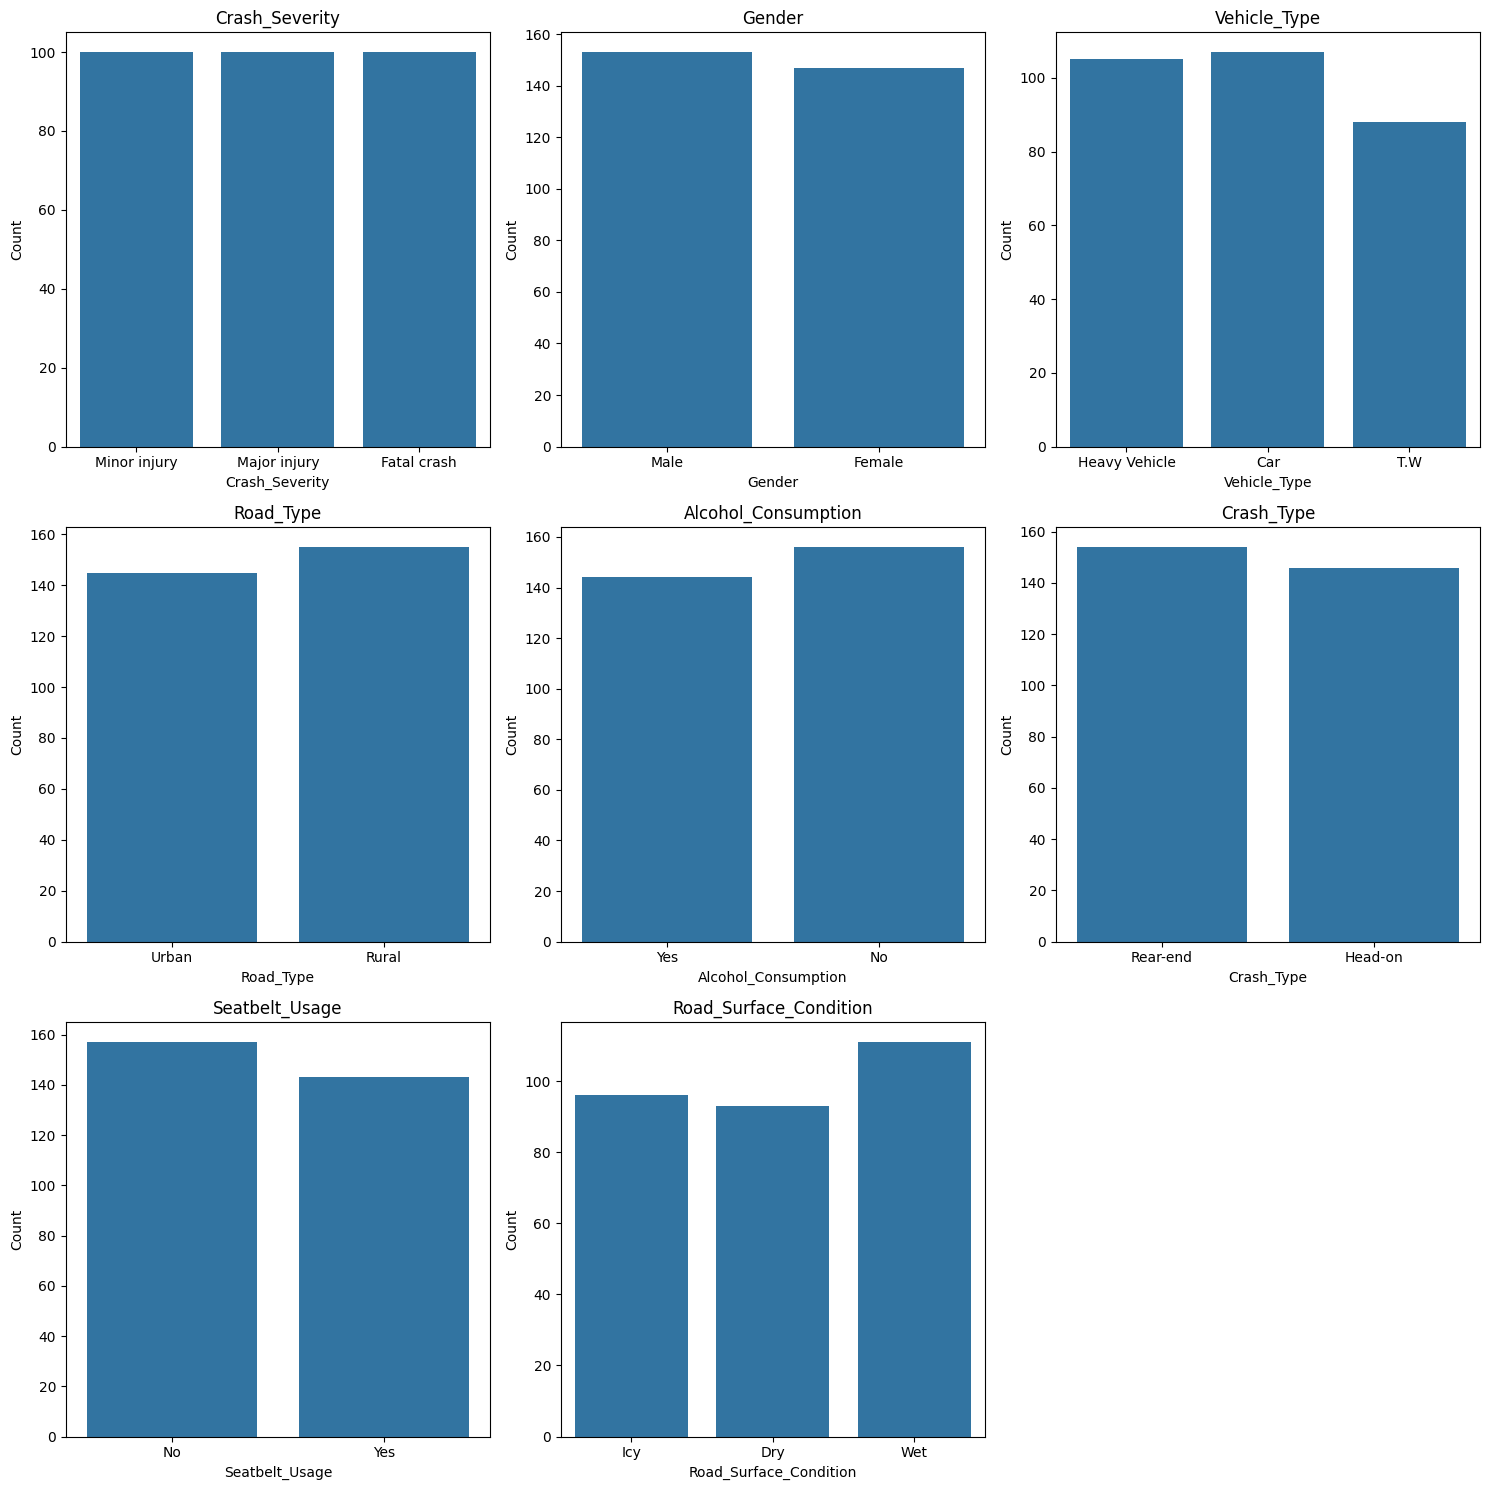

In [6]:
# Determine the number of object-type columns
columns = data.select_dtypes(include=['object']).columns
num_columns = len(columns)

# Define the grid: 3 columns per row
ncols = 3
nrows = math.ceil(num_columns / ncols)

# Create subplots with the required grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each categorical column
for i, column in enumerate(columns):
    sns.countplot(x=column, data=data, ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")

# Hide unused axes
for j in range(len(columns), len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Bivariate data analysis


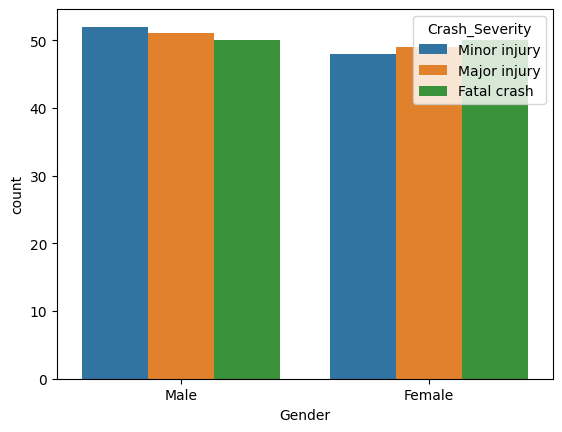

In [7]:
##is gender useful in predicting

sns.countplot(x = 'Gender' , hue = 'Crash_Severity' , data = data)
plt.show()

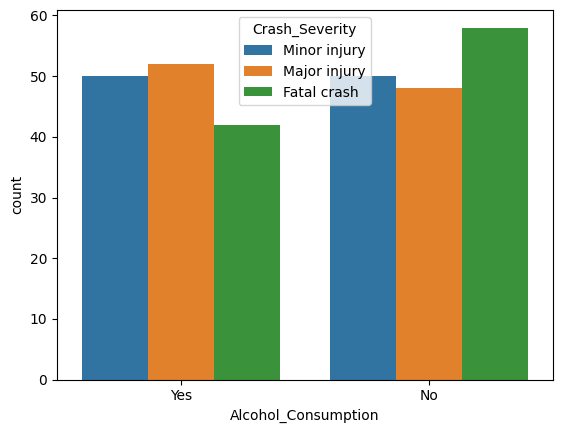

In [8]:
##is Alcohol consumption useful in predicting
sns.countplot(x = 'Alcohol_Consumption' , hue = 'Crash_Severity' , data = data)
plt.show()

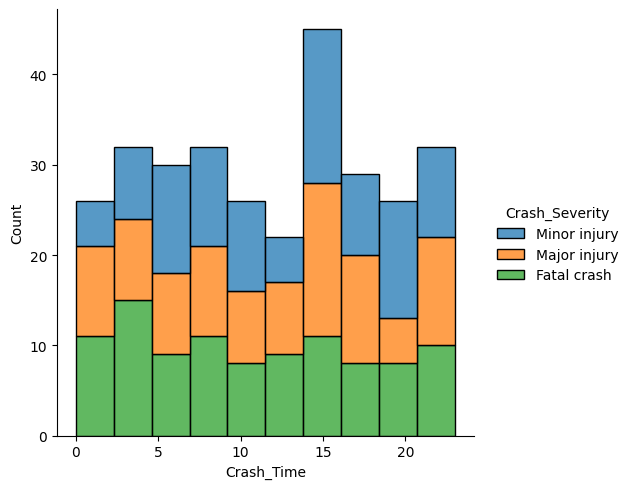

In [9]:
##is Crash time useful in predicting
sns.displot(x = 'Crash_Time' , hue = 'Crash_Severity' , data = data , multiple="stack")
plt.show()

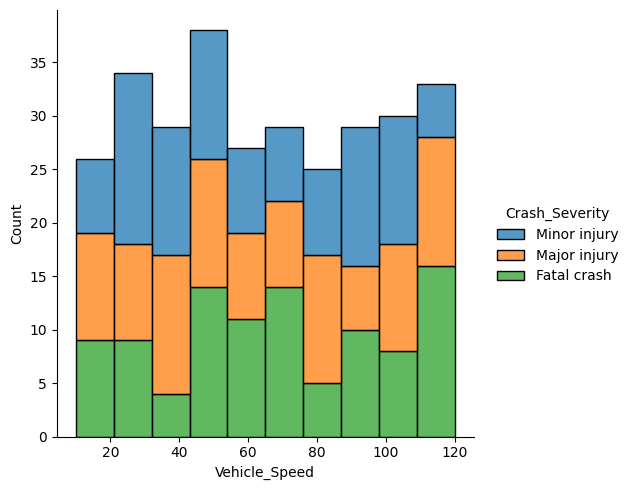

In [10]:
##is vehicle speed useful in predicting
sns.displot(x = 'Vehicle_Speed' , hue = 'Crash_Severity' , data = data , multiple="stack")
plt.show()

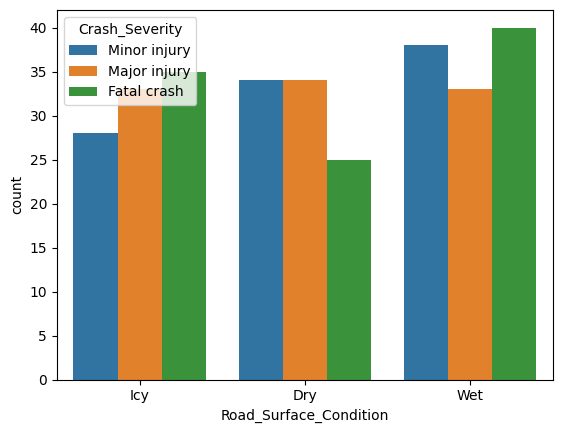

In [11]:
##is road surface condition useful in predicting
sns.countplot(x = data['Road_Surface_Condition'] , hue = data['Crash_Severity'])
plt.show()

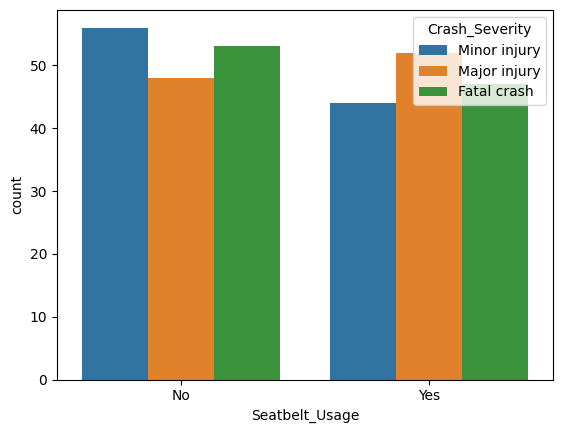

In [12]:
##is seatbelt usage condition useful in predicting
sns.countplot(x = data['Seatbelt_Usage'] , hue = data['Crash_Severity'])
plt.show()

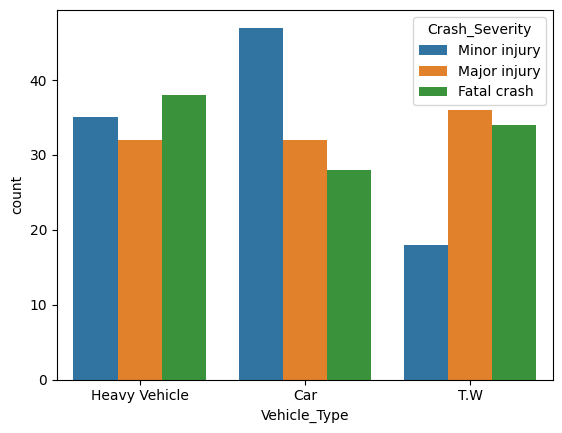

In [13]:
##is Vehicle type useful in predicting
sns.countplot(x = data['Vehicle_Type'] , hue = data['Crash_Severity'])
plt.show()

Conculsion from graphs 

*Gender* - 
The counts of Minor injuries, Major injuries, and Fatal crashes are relatively consistent between males and females.
This suggests that gender may not be a strong predictor of crash severity on its own, as the severity distribution does not vary significantly between the two groups.

*Vehicle speed* -
Vehicle speed is a critical factor in predicting crash severity since there is a clear correlation between increasing speed and crash severity, especially Fatal crashes.

*Alcohol cosumption* -
The chart seems counterintuitive at first glance since alcohol consumption is typically expected to increase crash severity. However, the data could suggest:
Non-alcohol-related crashes might involve other factors like speed, poor road conditions, or lack of seatbelt usage, contributing to Fatal crashes.

*Road surface condtions* -
Road surface conditions significantly influence crash severity and can be used as a feature in predictive models.
Wet and icy conditions seem to correlate with severe outcomes (fatal or major injuries), making it essential to consider them in accident risk models.
Dry conditions may act as a baseline or lower-risk scenario in predictive analysis

*Seatbelt usage* -
Seatbelt Usage would be a strong feature, indicating that wearing a seatbelt decreases the likelihood of severe or fatal injuries.
Including this feature could enhance the model's accuracy for predicting crash outcomes and categorizing severity levels.

*Vehicle type* -
Vehicle Type would be an important predictive feature:
Two-wheelers might correlate strongly with fatal crashes, increasing the risk of high-severity outcomes.
Cars are more likely to result in minor injuries.
Heavy vehicles could vary depending on other factors (e.g., speed, collision type).

**Feature Engineering**


In [14]:
##Speed over Limit = Vehicle_Speed - Speed_Limit(This highlights driving behavior regarding overspeeding.)
data['speed_over_limit'] = data['Vehicle_Speed'] - data['Speed_Limit']
data['speed_over_limit'] = data['speed_over_limit'].apply(lambda x : max(0 , x))

**Encoding**

In [15]:
#Encode categorical features
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [16]:
#Randomize the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

**Split data into x and y**

In [17]:
#Split features and target
X = data.drop(['Crash_Severity'], axis=1)
y = data['Crash_Severity']

In [18]:
y.head()

0    0
1    0
2    1
3    2
4    0
Name: Crash_Severity, dtype: int32

**Normalization**


In [19]:
#Scale numeric features
scaler = StandardScaler()
X[X.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(
    X.select_dtypes(include=['float64', 'int64'])
)

**Handling imbalance data**


In [20]:
#Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

**Train-Test-Split**

In [21]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [22]:
#Define Models
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200 , class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

In [23]:
# Train and evaluate each model
feature_importances = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Store feature importances if available
    if hasattr(model, 'feature_importances_'):
        feature_importances[model_name] = model.feature_importances_


RandomForest Accuracy: 0.6667
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

Confusion Matrix:
 [[0 1]
 [0 2]]
XGBoost Accuracy: 0.3333
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.50      0.50      0.50         2

    accuracy                           0.33         3
   macro avg       0.17      0.17      0.17         3
weighted avg       0.33      0.33      0.33         3

Confusion Matrix:
 [[0 0 1]
 [0 0 0]
 [0 1 1]]


c:\Users\atuly\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\atuly\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\atuly\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [24]:
# Step 9: Display Top Features for Each Model
for model_name, importances in feature_importances.items():
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    print(f"\nTop Features for {model_name}:")
    print(importance_df.head(10))


Top Features for RandomForest:
                Feature  Importance
1            Crash_Time    0.171389
5       Number_of_Lanes    0.120404
6            Lane_Width    0.085288
0         Vehicle_Speed    0.084761
8   Alcohol_Consumption    0.084715
3                Gender    0.083504
2                   Age    0.079634
9            Crash_Type    0.077415
13     speed_over_limit    0.070316
11          Speed_Limit    0.047225

Top Features for XGBoost:
                Feature  Importance
8   Alcohol_Consumption    0.227583
3                Gender    0.224946
1            Crash_Time    0.221162
9            Crash_Type    0.186598
2                   Age    0.116162
0         Vehicle_Speed    0.023166
11          Speed_Limit    0.000236
10       Seatbelt_Usage    0.000148
4          Vehicle_Type    0.000000
5       Number_of_Lanes    0.000000


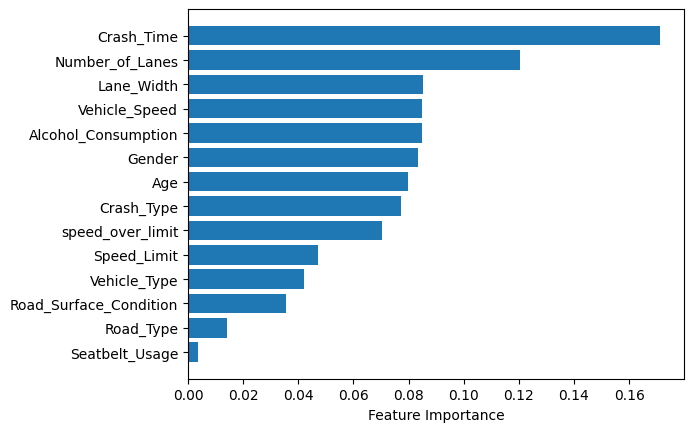

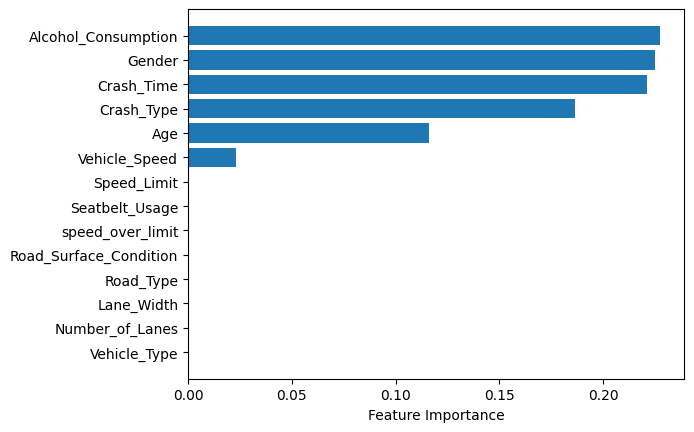

In [24]:
#Features importance shown using graps
for model_name, model in models.items():
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()
    plt.barh(X_train.columns[sorted_idx], feature_importances[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.show()

**Safety Improvement Suggestions**
1. ***Enforce Speed Limits and Introduce Speed Control Measures***

Insights from Data: Higher vehicle speeds are strongly correlated with fatal crashes.

Recommendations:
  * Install speed cameras in high-risk areas.
  * Implement dynamic speed limits that adjust based on traffic, weather, and time of day.
  * Use speed bumps and rumble strips on accident-prone roads to slow down vehicles.


2. ***Improve Road Design and Infrastructure***

Insights from Data: Narrow lanes, poor road conditions, and urban areas with high traffic volumes contribute to higher crash severity.

Recommendations:
  * Widen lanes and ensure uniform lane width across highways and busy roads.
  * Invest in road surface maintenance to reduce the impact of wet or icy conditions.
  * Enhance road signage and lighting, especially in urban and rural areas with limited visibility.


3. ***Increase Awareness About Safety Practices***

Insights from Data: Non-compliance with seatbelt usage and alcohol consumption are significant risk factors for severe crashes.

Recommendations:
  * Launch public campaigns emphasizing the importance of seatbelt usage.
  * Introduce stricter DUI (Driving Under Influence) checks, especially during peak hours or holidays.


4. ***Incorporate Smart Technologies***

Insights from Data: Weather conditions and traffic volumes significantly affect crash severity.

Recommendations:
   * Use IoT devices to monitor real-time weather and road conditions.
   * Implement AI-based traffic management systems to optimize flow and reduce congestion.


5. ***Educate Drivers Through Training Programs***

Insights from Data: Driver behavior (speeding, alcohol consumption) is a major contributor to crash severity.

Recommendations:
  * Introduce mandatory defensive driving courses for license renewals.
  * Conduct workshops on the impact of distracted driving and risky behaviors.




